In [1]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import random
import math
import pickle
import unicodedata

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as st
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

from datetime import datetime, timedelta
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from sklearn.preprocessing import StandardScaler

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import robject

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

rTE = importr('RTransferEntropy')
rTE.set_quiet(True)

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f91fe3ab0c0> [RTYPES.NILSXP]

In [3]:
from utils_p import *

In [4]:
# setup seed
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

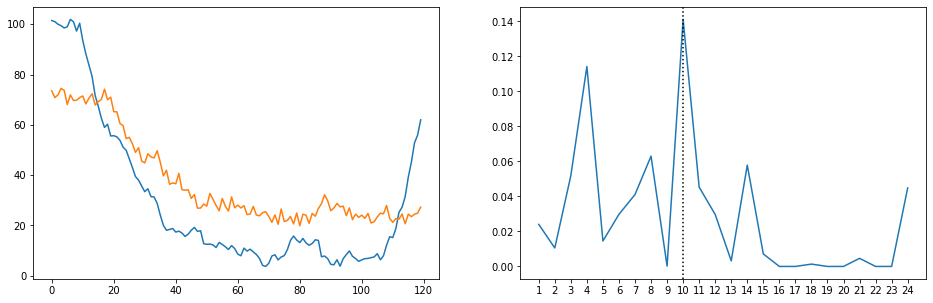

In [5]:
n = 120

while True:
    x = [100] * n + np.random.normal(0, 1, n)*2
    # for i in range(10): 
    #     x[i] = x[i] + np.random.normal(0, 10)

    for i in np.arange(10,n):
        if i < 100:
            x[i] = 0.95 * x[i-1] + np.random.normal(0,1)*2
        else: 
            x[i] = 1.10 * x[i-1] + np.random.normal(0,1)*2
    x = pd.Series(x)

    if np.min(x) > 0:
        break

lag = 10
k = 0

while True:
    random.seed(k)
    np.random.seed(k)
    
    y = [70] * n + np.random.normal(0, 1, n)*2
    for i in range(lag, n):
        y[i] = 0.5 * x[i-lag] + 20 + np.random.normal(0,1)*2
    y = pd.Series(y)

    out = []
    for lag_test in np.arange(1,25,1):
        x_copy = x.to_numpy().copy()
        y_copy = y.to_numpy().copy()

        ETE_value = rTE.calc_ete(x = x_copy[1:(len(x_copy)-lag_test)+1], y = y_copy[(lag_test):len(y_copy)],lx=1,ly=1)
        out.append([lag_test, np.asarray(ETE_value).item()])
        
    #check TE
    if lag == (np.argmax(np.array(out)[:,1])+1):
        fig, ax = plt.subplots(1, 2, figsize=(16,5))
        ax[0].plot(x)
        ax[0].plot(y)

        ax[1].plot(np.array(out)[:,0], np.array(out)[:,1])
        ax[1].set_xticks(np.arange(1,25))
        ax[1].axvline(lag, color='k', ls=':')

        plt.show()
        break
    
    k += 1

In [6]:
df = pd.DataFrame([x,y], index=['x', 'y']).T

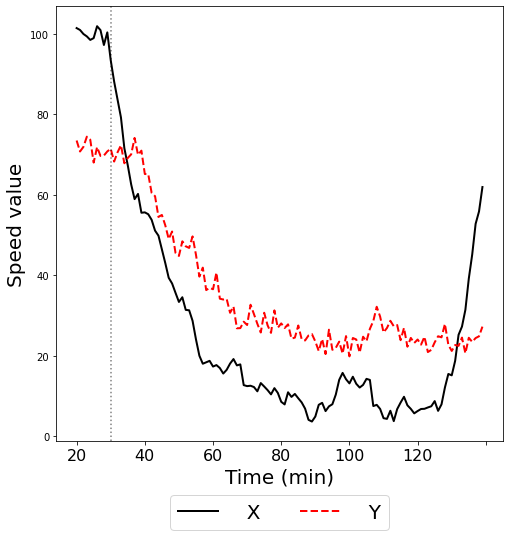

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(x.reset_index(drop=True), color='k', lw=2)
ax.plot(y.reset_index(drop=True), color='r', ls='dashed', lw=2)
# ax[0].legend(['X', 'Y'], loc=1, fontsize=24)
ax.legend(['  X','  Y'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=20)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.set_xticklabels(np.arange(0,140,20), fontsize=16)

plt.savefig('raw.png', bbox_inches='tight')

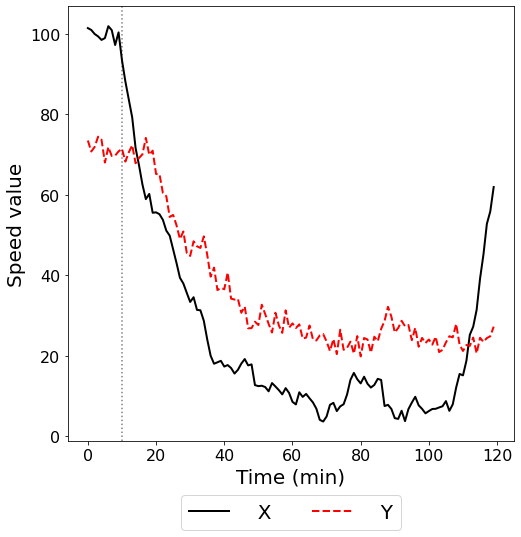

In [8]:
# save fig 1
raw = False
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.plot(x.reset_index(drop=True), color='k', lw=2)
ax.plot(y.reset_index(drop=True), color='r', ls='dashed', lw=2)
ax.legend(['  X','  Y'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=20)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
ax.set_xticks(np.arange(0,140,20))
ax.set_xticklabels(np.arange(0,140,20), fontsize=16)
if raw:
    ax.set_yticks(0.1*np.arange(0,12,2))
    ax.set_yticklabels(0.1*np.arange(0,12,2), fontsize=16)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
else:
    ax.set_yticks(np.arange(0,120,20))
    ax.set_yticklabels(np.arange(0,120,20), fontsize=16)
ax.set_xlabel('Time (min)', fontsize=20)
if raw:
    ax.set_ylabel('Normalized speed value', fontsize=20)
else:
    ax.set_ylabel('Speed value', fontsize=20)           
# plt.savefig('raw.png', bbox_inches='tight')
plt.show()

In [9]:
df_diff = df.pct_change(1).dropna()

In [10]:
df_diff = np.log(df).diff(1).dropna()

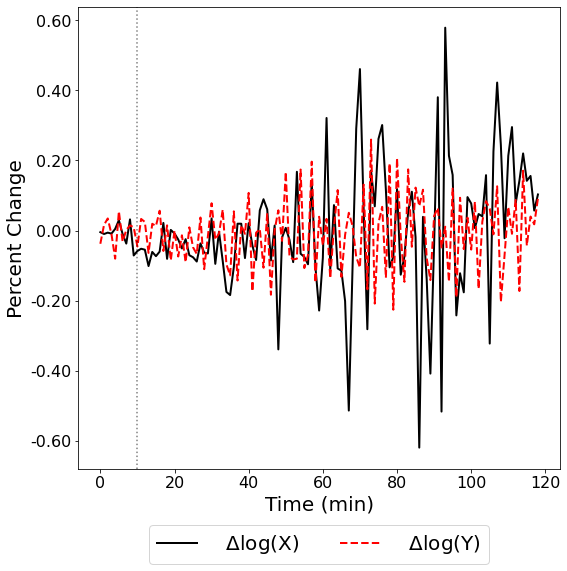

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(df_diff['x'].reset_index(drop=True), color='k', lw=2)
ax.plot(df_diff['y'].reset_index(drop=True), color='r', ls='dashed', lw=2)
# ax[0].legend(['X', 'Y'], loc=1, fontsize=24)
ax.legend([r'  $\Delta\log$(X)',r'  $\Delta\log$(Y)'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=20)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Percent Change', fontsize=20)
ax.set_xticks(np.arange(0,140,20))
ax.set_xticklabels(np.arange(0,140,20), fontsize=16)
ax.set_yticks(0.1*np.arange(-6,8,2))
ax.set_yticklabels(0.1*np.arange(-6,8,2), fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.tight_layout()
# plt.savefig('diff.png', bbox_inches='tight')
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['x'].values)
print('ADF Statistics: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['y'].values)
print('ADF Statistics: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistics: -1.903298
p-value: 0.330511
ADF Statistics: -2.077500
p-value: 0.253657


In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_diff['x'].values)
print('ADF Statistics: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df_diff['y'].values)
print('ADF Statistics: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistics: -9.684533
p-value: 0.000000
ADF Statistics: -10.793640
p-value: 0.000000


In [14]:
out_all = []

# pearson correlation
corr_out = []
for i in np.arange(1,25):
    corr_out.append([i, df['x'].iloc[i:].corr(df['y'].iloc[:-i])])
corr_out = np.array(corr_out)
top_lag = corr_out[np.argmax(corr_out[:,1])][0]
out_all.append(top_lag)

# pearson correlation
corr_out = []
for i in np.arange(1,25):
    corr_out.append([i, df_diff['x'].iloc[i:].corr(df_diff['y'].iloc[:-i])])
corr_out = np.array(corr_out)
top_lag = corr_out[np.argmax(corr_out[:,1])][0]
out_all.append(top_lag)

# VAR model
model = VAR(df)
var_out = []
for i in np.arange(1,25):
    result = model.fit(i)
    var_out.append([i, result.aic, result.bic, result.fpe, result.hqic])
var_out = np.array(var_out)
top_lag = var_out[np.argmin(var_out[:,1])][0]
out_all.append(top_lag)

# VAR model
model = VAR(df_diff)
var_out = []
for i in np.arange(1,25):
    result = model.fit(i)
    var_out.append([i, result.aic, result.bic, result.fpe, result.hqic])
var_out = np.array(var_out)
top_lag = var_out[np.argmin(var_out[:,1])][0]
out_all.append(top_lag)

/home/yongkyung/anaconda3/envs/traffic/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [15]:
# pearson correlation
corr_out = []
for i in np.arange(1,25):
    corr_out.append([i, df['x'].iloc[:-i].corr(df['y'].iloc[i:])])
corr_out = np.array(corr_out)
top_lag = corr_out[np.argmax(corr_out[:,1])][0]
out_all.append(top_lag)

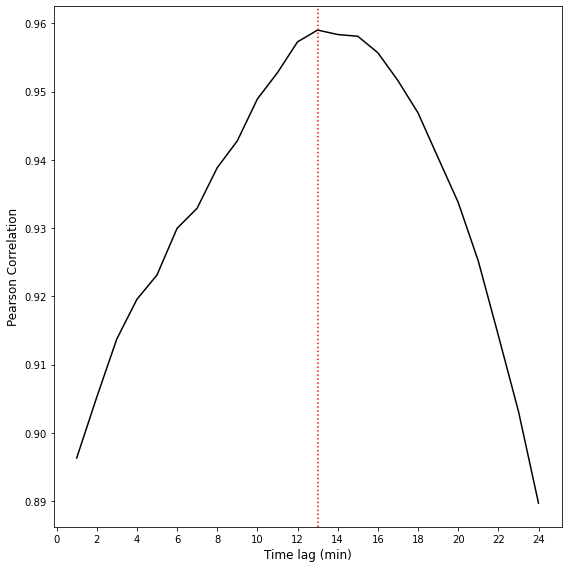

In [16]:
plt.figure(figsize=(8,8))
plt.plot(corr_out[:,0], corr_out[:,1], color='k')
plt.axvline(top_lag, color='r', ls=':')
plt.xticks(np.arange(0,25,2))
plt.xlabel('Time lag (min)', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
# pearson correlation
corr_out = []
for i in np.arange(1,25):
    corr_out.append([i, df_diff['x'].iloc[:-i].corr(df_diff['y'].iloc[i:])])
corr_out = np.array(corr_out)
top_lag = corr_out[np.argmax(corr_out[:,1])][0]
out_all.append(top_lag)

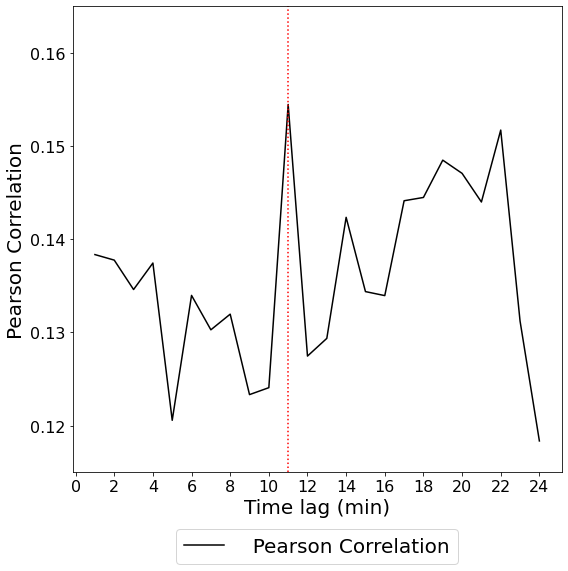

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(corr_out[:,0], corr_out[:,1], color='k', label='corr')
ax.axvline(top_lag, color='r', ls=':')
ax.set_xlabel('Time lag (min)', fontsize=20)
ax.set_ylabel('Pearson Correlation', fontsize=20)
ax.set_xticks(np.arange(0,25,2))
ax.set_xticklabels(np.arange(0,25,2), fontsize=16)
ax.set_ylim(0.115,0.165)
ax.set_yticks(0.01*np.arange(12,17,1))
ax.set_yticklabels(0.01*np.arange(12,17,1), fontsize=16)
ax.legend(['  Pearson Correlation'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=20)
plt.tight_layout()
plt.show()

In [19]:
from statsmodels.tsa.api import VAR
model = VAR(df)

In [20]:
var_out = []
for i in np.arange(1,25):
    result = model.fit(i)
    var_out.append([i, result.aic, result.bic, result.fpe, result.hqic])
var_out = np.array(var_out)
top_lag = var_out[np.argmin(var_out[:,1])][0]
top_lag

11.0

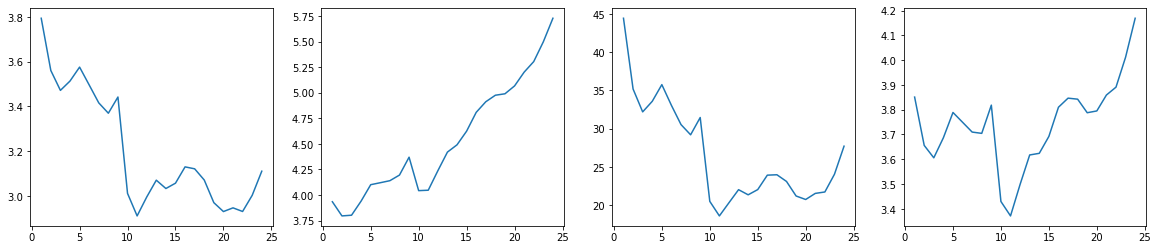

In [21]:
fig, ax = plt.subplots(1,4, figsize=(20,4))

for i in np.arange(1,5):
    ax[i-1].plot(var_out[:,0], var_out[:,i])

In [22]:
from statsmodels.tsa.api import VAR
model = VAR(df_diff)

/home/yongkyung/anaconda3/envs/traffic/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [23]:
var_out = []
for i in np.arange(1,25):
    result = model.fit(i)
    var_out.append([i, result.aic, result.bic, result.fpe, result.hqic])
var_out = np.array(var_out)
top_lag = var_out[np.argmin(var_out[:,1])][0]
top_lag

1.0

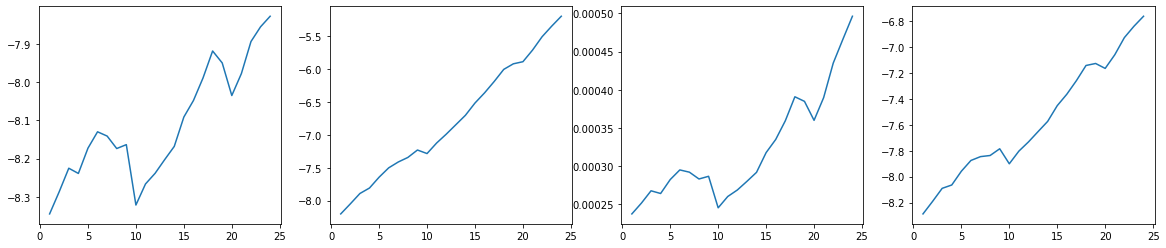

In [24]:
fig, ax = plt.subplots(1,4, figsize=(20,4))

for i in np.arange(1,5):
    ax[i-1].plot(var_out[:,0], var_out[:,i])

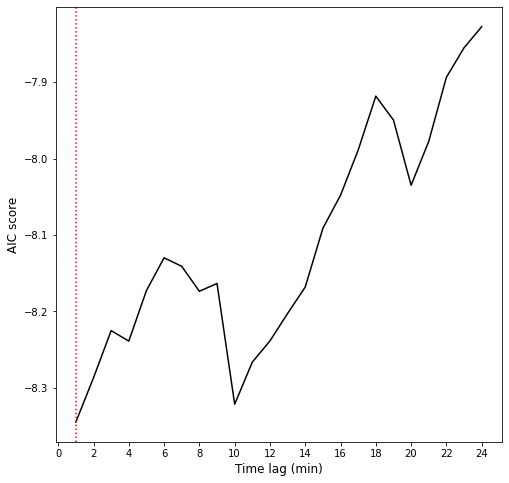

In [25]:
plt.figure(figsize=(8,8))
plt.plot(var_out[:,0], var_out[:,1], color='k')
plt.axvline(top_lag, color='r', ls=':')
plt.xticks(np.arange(0,25,2))
plt.xlabel('Time lag (min)', fontsize=12)
plt.ylabel('AIC score', fontsize=12)
plt.show()

In [26]:
import fathon
from fathon import fathonUtils as fu

x_f = fu.toAggregated(x)
y_f = fu.toAggregated(y)

In [27]:
pydcca = fathon.DCCA(x_f, y_f)
winSizes = fu.linRangeByStep(3, 120, step=1)
polOrd = 1

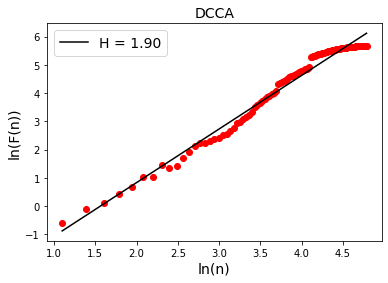

In [28]:
n, F = pydcca.computeFlucVec(winSizes, polOrd=polOrd)
H, H_intercept = pydcca.fitFlucVec()

plt.plot(np.log(n), np.log(F), 'ro')
plt.plot(np.log(n), H_intercept+H*np.log(n), 'k-', label='H = {:.2f}'.format(H))
plt.xlabel('ln(n)', fontsize=14)
plt.ylabel('ln(F(n))', fontsize=14)
plt.title('DCCA', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

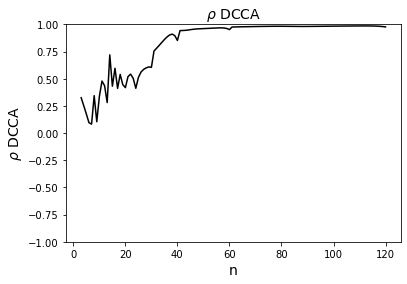

In [29]:
n, rho = pydcca.computeRho(winSizes, polOrd=polOrd)

plt.plot(n, rho, 'k')
plt.ylim(-1, 1)
plt.xlabel('n', fontsize=14)
plt.ylabel(r'$\rho$ DCCA', fontsize=14)
plt.title(r'$\rho$ DCCA', fontsize=14)
plt.show()

In [30]:
def get_rhoDCCA(x,y):
    x_f = fu.toAggregated(x)
    y_f = fu.toAggregated(y)

    pydcca = fathon.DCCA(x_f, y_f)
    winSizes = fu.linRangeByStep(6, 10, step=2) # n size
    polOrd = 1

#     n, F = pydcca.computeFlucVec(winSizes, polOrd=polOrd)
#     H, H_intercept = pydcca.fitFlucVec()
    n, rho = pydcca.computeRho(winSizes, polOrd=polOrd)
    
    return pd.DataFrame(rho, index=n)

In [31]:
# rhoDCCA
corr_out = []
for i in np.arange(1,25):
    rhoDCCA = get_rhoDCCA(df_diff['x'].iloc[:-i].to_numpy(),df_diff['y'].iloc[i:].to_numpy())
    rhoDCCA.columns = [i]
    corr_out.append(rhoDCCA)

In [32]:
corr_out_df = pd.concat(corr_out, axis=1)

In [33]:
corr_out_df.T.idxmax().tolist()

[10, 10, 22]

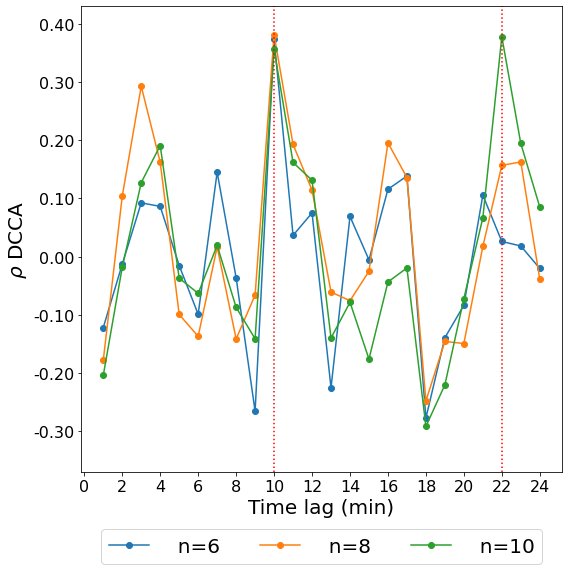

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(corr_out_df.T, marker='o')
ax.axvline(10, color='r', ls=':')
ax.axvline(22, color='r', ls=':')
ax.set_xlabel('Time lag (min)', fontsize=20)
ax.set_ylabel(r'$\rho$ DCCA', fontsize=20)
ax.set_xticks(np.arange(0,25,2))
ax.set_xticklabels(np.arange(0,25,2), fontsize=16)
ax.set_ylim(-0.37,0.43)
ax.set_yticks(0.1*np.arange(-3,5,1))
ax.set_yticklabels(0.1*np.arange(-3,5,1), fontsize=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.legend(['  n=6', '  n=8', '  n=10'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=20)
plt.tight_layout()
plt.show()